#### Problem Statement: With resources for mental health being so limited in the US, and culture suppressing those who need help from seeking it, it would be immensely valuable to provide a model which could predict whether an individual was suffering from various mental health issues using sentiment analysis as a backbone for classification. We'll use Recall/Sensitivity as our main metric since False Positives would suggest people get help when they may not necessarily need (but everyone needs it) vs a false negative that could minimize serious health issues. We'll set our target at least 95% recall before production-ready.

In [47]:
import pandas as pd
import numpy as np
import random

import re

import spacy

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

### Setting the random seed

In [3]:
random.seed(42)

In [4]:
df2 = pd.read_csv('../data/sentiment.csv').drop(columns=['Unnamed: 0'])

In [5]:
df2.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


#### A few notes from what we discussed with Hank:
#### * CountVectorizer and TfidfVectorizer in SKlearn can be used in a Pipeline and GridSearched over.
#### * You can do this all locally
#### * Multinomial Naive Bayes also does well with the CVEC and Tfidf Vectorizers

---------

### Reloaded data as df2 to start with  CountVectorizer

### Basic EDA

In [7]:
df2.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [8]:
df2.shape

(53043, 2)

In [9]:
df2.dtypes

statement    object
status       object
dtype: object

In [10]:
df2.isnull().sum()

statement    362
status         0
dtype: int64

#### Only 362 rows out of 53,043 so will drop the rows with null values

In [11]:
df2_cleaned = df2.dropna()

In [12]:
df2_cleaned.shape

(52681, 2)

In [13]:
df2_cleaned.isnull().sum()

statement    0
status       0
dtype: int64

In [14]:
vectorizer = CountVectorizer(stop_words='english')
df2_cleaned_statement_vectorized = vectorizer.fit_transform(df2_cleaned['statement'])

#### df2_cleaned_statement_vectorized is a sparse matrix

In [15]:
df2_cleaned_statement_vectorized.shape

(52681, 58930)

In [16]:
vectorizer.vocabulary_

{'oh': 37004,
 'gosh': 22810,
 'trouble': 53560,
 'sleeping': 47541,
 'confused': 11893,
 'mind': 33619,
 'restless': 43850,
 'heart': 24243,
 'tune': 53760,
 'wrong': 57886,
 'dear': 13888,
 'forward': 21049,
 'doubt': 16327,
 'stay': 49212,
 'place': 39770,
 've': 55559,
 'shifted': 46637,
 'focus': 20758,
 'worried': 57697,
 'month': 34310,
 'boy': 8183,
 'mean': 32772,
 'break': 8332,
 'nervous': 35692,
 'like': 30827,
 'heck': 24311,
 'feel': 19912,
 'scared': 45425,
 'anxious': 4492,
 'family': 19571,
 'protected': 41279,
 'felt': 19981,
 'didn': 15104,
 'know': 29646,
 'haven': 24065,
 'slept': 47562,
 'days': 13764,
 'huh': 25455,
 'really': 42593,
 'want': 56448,
 'night': 35967,
 'don': 16181,
 'strange': 49586,
 'feeling': 19917,
 'good': 22723,
 'lately': 30186,
 'time': 52427,
 'sleep': 47533,
 'needed': 35548,
 'problem': 40980,
 'laugh': 30220,
 'forget': 20956,
 'remember': 43389,
 'turns': 53798,
 'sad': 44956,
 'burden': 8845,
 'blah': 7537,
 'worry': 57707,
 'thought

In [17]:
# df2_cleaned_statement_vectorized.toarray()

#### Need to store the vectorized data to use for modeling

In [18]:
# df2_cleaned['statement_vectorized'] = [row for row in df2_cleaned_statement_vectorized.toarray()]

#### I cannot get the sparse matrix to save to an array or convert to a DataFrame because it is too big. I am going to try to tie everything in a pipeline.

#### Checking values in the target variable

In [65]:
df2_cleaned['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

#### Want to put the target variable into 2 categories, positive and negative

 #### Setting 'Normal' to have a value of 1 and all other status as a value of 0 to use as the positive/ negative target variable/

In [19]:
df2_cleaned['status'] = df2_cleaned['status'].map({'Normal':1}).fillna(0).astype(int)

C:\Users\Beau_\AppData\Local\Temp\ipykernel_29468\1978066555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_cleaned['status'] = df2_cleaned['status'].map({'Normal':1}).fillna(0).astype(int)


In [20]:
df2_cleaned['status'].value_counts()

status
0    36338
1    16343
Name: count, dtype: int64

In [21]:
df2_cleaned['status'].dtypes

dtype('int64')

In [22]:
df2_cleaned.shape

(52681, 2)

#### Setting X and y variables

In [23]:
X = df2_cleaned['statement']

y = df2_cleaned['status']

#### The text needs to be not in a DataFrame so CountVectorizer can properly transform the text

In [24]:
X.head()

0                                           oh my gosh
1    trouble sleeping, confused mind, restless hear...
2    All wrong, back off dear, forward doubt. Stay ...
3    I've shifted my focus to something else but I'...
4    I'm restless and restless, it's been a month n...
Name: statement, dtype: object

In [25]:
X.shape

(52681,)

In [26]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: status, dtype: int64

In [27]:
y.shape

(52681,)

#### Splitting into train and test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

#### Baseline

In [29]:
y_test.value_counts(normalize = True)

status
0    0.689773
1    0.310227
Name: proportion, dtype: float64

#### Building pipeline with vectorizer and logistic regression

In [30]:
pipeline_logr = Pipeline([
    ('vector', CountVectorizer(stop_words='english')),
    ('logr', LogisticRegression(random_state=42))
])

In [31]:
pipeline_logr_params = {'logr__penalty': ['l1', 'l2'],
                        'logr__C': [1.0, 0.5, 0.1]}

In [32]:
gs_logr = GridSearchCV(pipeline_logr, pipeline_logr_params, cv=5, verbose=1, n_jobs=-1)

In [33]:
gs_logr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Beau_\virtual\dsb_602\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Beau_\virtual\dsb_602\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Beau_\virtual\dsb_602\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Beau_\virtual\dsb_602\Lib\site-packages\sklearn\pipeline.py", line 661, in fit
    s

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'logr__C': [1.0, 0.5, ...], 'logr__penalty': ['l1', 'l2']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [34]:
print(f'Train: {gs_logr.score(X_train, y_train)}')
print(f'Test: {gs_logr.score(X_test, y_test)}')
print(f'Recall: {recall_score(y_test, gs_logr.predict(X_test))}')

Train: 0.9804859529233105
Test: 0.9434363374079416
Recall: 0.933920704845815


### Recall(Sensitivity) $ tp / (tp + fn) $

In [35]:
pred = gs_logr.predict(X_test)

In [36]:
cm = confusion_matrix(y_test, pred)

In [37]:
cm

array([[8610,  475],
       [ 270, 3816]])

In [39]:
cm.ravel()

array([8610,  475,  270, 3816])

In [40]:
tn, fp, fn, tp = cm.ravel()

In [41]:
df_cm = pd.DataFrame(cm,
                    columns=['pred_normal', 'pred_mental_concern'],
                    index=['actual_normal', 'actual_mental_concern'])
df_cm

,pred_normal,pred_mental_concern
actual_normal,8610,475
actual_mental_concern,270,3816


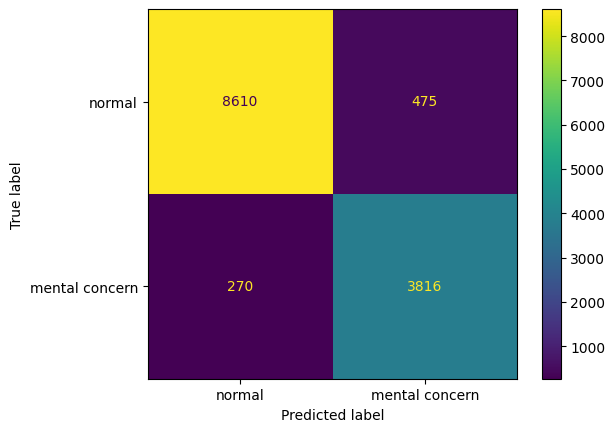

In [44]:
ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=['normal', 'mental concern']).plot();

In [48]:
metrics.f1_score(y_test, pred)

0.9110660140861884